# Training the model on images

Model trained with L-fine-tuned.

## Imports

In [1]:
# load custom scripts
from dataset import Dataset2
from utils import *
import config 

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from utils import EarlyStopping
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.express as px
import plotly.graph_objects as go
import random
import segmentation_models_pytorch as smp
import time
import torch
import torchmetrics
import os

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Setup CUDA

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [4]:
# load the image and label filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images("/data/jantina/data/CoralNet/inference/images/train/")))
labelPaths = sorted(list(paths.list_images("/data/jantina/data/CoralNet/inference/labels/train/")))

trainImages, valImages, trainLabels, valLabels = train_test_split(imagePaths,
                                                                  labelPaths,
                                                                  test_size=0.2,
                                                                  train_size=0.8,
                                                                  random_state=SEED)

## Example

In [5]:
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: '(macro) algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [6]:
a=random.randrange(len(trainImages))
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])

print(f"Image name: {trainImages[a].split('/')[-1]}")
print(f"Image dtype: {image.dtype}, Label dtype: {label.dtype}")

Image name: 0000029_580_0.png
Image dtype: uint8, Label dtype: uint8


In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)

cax = ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20b', 10), vmin = 0, vmax = 9)

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()]
)

In [9]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
)

In [10]:
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
transformed = train_transform(image=image, mask=label)
image = transformed["image"]
label = transformed["mask"]
            
# convert label and mask to long tensor
label = label.type(torch.LongTensor)

/tmp/ipykernel_1089265/4094310088.py:8: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



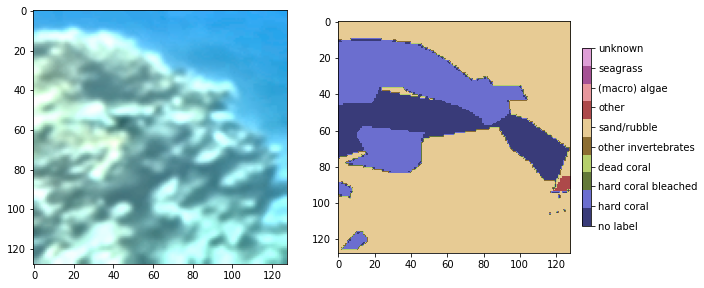

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].imshow(unnormalize(image).permute(1, 2, 0))

ax[1].imshow(label,
             cmap = plt.cm.get_cmap('tab20b', 10), 
             vmin=0, vmax=9)

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Create dataset

In [12]:
# create the train and validation datasets
trainDS = Dataset2(imagePaths=trainImages, labelPaths = trainLabels, transform=train_transform)
valDS = Dataset2(imagePaths=valImages, labelPaths = valLabels, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")

[INFO] found 44 examples in the training set
[INFO] found 12 examples in the validation set


In [15]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}, Feature type: {sample[0].dtype}")
print(f"Label shape: {sample[1].shape}, Label type: {sample[1].dtype}")

Feature shape: torch.Size([3, 128, 128]), Feature type: torch.float32
Label shape: torch.Size([128, 128]), Label type: torch.int64


In [16]:
config.BATCH_SIZE = len(valDS)

In [17]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True,
                         worker_init_fn=seed_worker)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True,
                       worker_init_fn=seed_worker)

In [18]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:12
[INFO] num_workers:32


## Model 

In [19]:
# import the pretrained model
unet = torch.load("/data/jantina/data/CoralNet/dataset/output/weighted.pth").to(config.DEVICE)

## Freeze layers

In [20]:
for name, param in unet.named_parameters():
    if not 'segmentation_head' in name:
        param.requires_grad = False

## Initizalize

In [21]:
# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=0)

# initialize optimizer
opt = Adam(filter(lambda p: p.requires_grad, unet.parameters()), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = -(-len(trainDS) // config.BATCH_SIZE)
valSteps = -(-len(valDS) // config.BATCH_SIZE)

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

In [22]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)

# move the metrics to device
acc.to(config.DEVICE)

# initialize a dictionary to store metrics history
metrics = {"train_accuracy": [], "val_accuracy": []}

In [23]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True, 
                               path="/data/jantina/data/CoralNet/inference/output/checkpoint.pt")

In [24]:
#initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, "min", patience=4, verbose=1)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

## Training loop

In [25]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    #fix seed
    seed_all(SEED)
    
    ###################
    # train the model #
    ###################
    unet.train() # prep model for training

    # initialize the total training and validation loss
    totalTrainLoss, totalValLoss = 0, 0
    
    # initialize the accuracy
    accTrain = 0
    accVal = 0
    
    # loop over the training set
    for batch, (data, target) in enumerate(trainLoader, 1):
        #fix seed
        seed_all(SEED)
        
        # send the input to the device
        (data, target) = (data.to(config.DEVICE), target.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(data)

        # calculate the training loss
        loss = lossFunc(pred, target)
        
        # Gradient descent with optimizer:
        opt.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(opt)
        grad_scaler.update()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
                
        # calculate the accuracy
        accTrain += acc(torch.argmax(pred,dim=1), target).item()
        
    ######################    
    # validate the model #
    ######################
    # switch off autograd
    with torch.no_grad():        
        unet.eval() # prep model for evaluation
        
        # loop over the validation set
        for data, target in valLoader:
            #fix seed
            seed_all(SEED)
            
            # send the input to the device
            (data, target) = (data.to(config.DEVICE), target.to(config.DEVICE))
        
            # make the predictions 
            pred = unet(data)
            
            # calculate the validation loss
            totalValLoss += lossFunc(pred, target).item()
            
            # scheduler step
            scheduler.step(lossFunc(pred, target))
            
            # calculate the accuracy
            accVal += acc(torch.argmax(pred,dim=1), target).item()

            '''
            # show the validation results
            fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
            ax[0].imshow(unnormalize(data[0]).cpu().detach().permute(1, 2, 0))

            ax[1].imshow(target[0].cpu(),
                         cmap = plt.cm.get_cmap('tab20b', 10), 
                         vmin=0, vmax=9)

            cax = ax[2].imshow(torch.argmax(pred[0],dim=0).cpu(),
                               cmap = plt.cm.get_cmap('tab20b', 10),
                               vmin=0, vmax=9)
            cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
            cbar.ax.set_yticklabels(list(classes.values()))
            plt.show()
            '''
            
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # calculate the average metrics
    avgaccTrain = accTrain / trainSteps
    avgaccVal = accVal / valSteps
    
    # update our metrics history
    metrics["train_accuracy"].append(avgaccTrain)
    metrics["val_accuracy"].append(avgaccVal)
    
    # check early stopping
    early_stopping(avgValLoss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
    # print the model metrics information
    print("Train Accuracy: {:.4f}".format(avgaccTrain))
    print("Validation Accuracy: {:.4f}".format(avgaccVal))
       
# load the last checkpoint with the best model
unet.load_state_dict(torch.load("/data/jantina/CoralNet/inference/output/checkpoint.pt"))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  1%|▊                                                                                     | 1/100 [00:02<04:53,  2.96s/it]

Validation loss decreased (inf --> 0.774209).  Saving model ...
[INFO] EPOCH: 1/100
Train loss: 1.238855, Validation loss: 0.7742
Train Accuracy: 0.6151
Validation Accuracy: 0.8348


  2%|█▋                                                                                    | 2/100 [00:03<02:19,  1.42s/it]

Validation loss decreased (0.774209 --> 0.734995).  Saving model ...
[INFO] EPOCH: 2/100
Train loss: 0.831885, Validation loss: 0.7350
Train Accuracy: 0.7394
Validation Accuracy: 0.8163


  3%|██▌                                                                                   | 3/100 [00:03<01:30,  1.07it/s]

Validation loss decreased (0.734995 --> 0.669333).  Saving model ...
[INFO] EPOCH: 3/100
Train loss: 0.962817, Validation loss: 0.6693
Train Accuracy: 0.7618
Validation Accuracy: 0.7963


  4%|███▍                                                                                  | 4/100 [00:04<01:07,  1.42it/s]

Validation loss decreased (0.669333 --> 0.590473).  Saving model ...
[INFO] EPOCH: 4/100
Train loss: 0.670763, Validation loss: 0.5905
Train Accuracy: 0.7888
Validation Accuracy: 0.8508


  5%|████▎                                                                                 | 5/100 [00:04<00:52,  1.79it/s]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 5/100
Train loss: 0.813122, Validation loss: 0.6371
Train Accuracy: 0.7525
Validation Accuracy: 0.8278


  6%|█████▏                                                                                | 6/100 [00:04<00:45,  2.07it/s]

Validation loss decreased (0.590473 --> 0.533958).  Saving model ...
[INFO] EPOCH: 6/100
Train loss: 0.754612, Validation loss: 0.5340
Train Accuracy: 0.7627
Validation Accuracy: 0.8518


  7%|██████                                                                                | 7/100 [00:04<00:39,  2.36it/s]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 7/100
Train loss: 0.712784, Validation loss: 5.2436
Train Accuracy: 0.7676
Validation Accuracy: 0.8546


  8%|██████▉                                                                               | 8/100 [00:05<00:35,  2.59it/s]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 8/100
Train loss: 0.737841, Validation loss: 7.6727
Train Accuracy: 0.7440
Validation Accuracy: 0.8346


  9%|███████▋                                                                              | 9/100 [00:05<00:34,  2.67it/s]

Validation loss decreased (0.533958 --> 0.348751).  Saving model ...
[INFO] EPOCH: 9/100
Train loss: 0.705250, Validation loss: 0.3488
Train Accuracy: 0.7628
Validation Accuracy: 0.9030


 10%|████████▌                                                                            | 10/100 [00:05<00:31,  2.89it/s]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 10/100
Train loss: 0.714939, Validation loss: 0.5645
Train Accuracy: 0.7520
Validation Accuracy: 0.8310


 11%|█████████▎                                                                           | 11/100 [00:06<00:29,  3.05it/s]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 11/100
Train loss: 0.687424, Validation loss: 0.5839
Train Accuracy: 0.7570
Validation Accuracy: 0.8121


 12%|██████████▏                                                                          | 12/100 [00:06<00:27,  3.16it/s]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 12/100
Train loss: 0.702031, Validation loss: 0.5656
Train Accuracy: 0.7336
Validation Accuracy: 0.8239


 13%|███████████                                                                          | 13/100 [00:06<00:26,  3.25it/s]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 13/100
Train loss: 0.738536, Validation loss: 0.6449
Train Accuracy: 0.7433
Validation Accuracy: 0.7987


 14%|███████████▉                                                                         | 14/100 [00:07<00:26,  3.30it/s]

Epoch    14: reducing learning rate of group 0 to 7.0000e-03.
EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 14/100
Train loss: 0.815844, Validation loss: 0.5153
Train Accuracy: 0.7445
Validation Accuracy: 0.8690


 15%|████████████▊                                                                        | 15/100 [00:07<00:25,  3.35it/s]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 15/100
Train loss: 0.697654, Validation loss: 0.6336
Train Accuracy: 0.7618
Validation Accuracy: 0.8150


 16%|█████████████▌                                                                       | 16/100 [00:07<00:24,  3.39it/s]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 16/100
Train loss: 0.689524, Validation loss: 0.3527
Train Accuracy: 0.7496
Validation Accuracy: 0.9107


 17%|██████████████▍                                                                      | 17/100 [00:07<00:24,  3.41it/s]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 17/100
Train loss: 0.736663, Validation loss: 0.5733
Train Accuracy: 0.7499
Validation Accuracy: 0.8499


 18%|███████████████▎                                                                     | 18/100 [00:08<00:24,  3.41it/s]

EarlyStopping counter: 9 out of 10
[INFO] EPOCH: 18/100
Train loss: 0.708453, Validation loss: 0.5073
Train Accuracy: 0.7627
Validation Accuracy: 0.8613


 18%|███████████████▎                                                                     | 18/100 [00:08<00:38,  2.12it/s]

Epoch    19: reducing learning rate of group 0 to 7.0000e-04.
EarlyStopping counter: 10 out of 10
Early stopping
[INFO] total time taken to train the model: 8.51s


## Plotting the loss

In [27]:
H = pd.DataFrame(H)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=H.index, y=H['train_loss'],
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=H.index, y=H['validation_loss'],
                    mode='lines',
                    name='Validation Loss'))

fig.update_layout(title='Training and Testing Loss on Dataset',
                   xaxis_title='Epoch #',
                   yaxis_title='Loss')

fig.update_xaxes(range = [-1,19])
fig.update_yaxes(range = [0,4])

fig.show()

## Plotting the metrics

In [28]:
metrics = pd.DataFrame(metrics)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracy'],
                    mode='lines',
                    name='Training accuracy'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracy'],
                    mode='lines',
                    name='Validation accuracy'))

fig.update_layout(title='Metrics',
                   xaxis_title='Epoch #',
                   yaxis_title='Accuracy')

fig.update_xaxes(range = [-1,19])
fig.update_yaxes(range = [0,1])

fig.show()


# Save model

In [ ]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in unet.state_dict():
    #print(param_tensor, "\t", unet.state_dict()[param_tensor].size())

In [29]:
# serialize the model to disk
torch.save(unet, "/data/jantina/data/CoralNet/dataset/output/eilat.pth")
#print("[INFO] model saved !")